In [1]:
import argparse
import copy
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import param
import panel as pn
import plotly.express as px

pn.extension('plotly')

from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionContext, ExecutionMode, Executor
from cadCAD import configs

from simulation import (CommonsSimulationConfiguration, bootstrap_simulation,
                        partial_state_update_blocks)

In [2]:
DATA_PATH = './data'

### Plotting methods

In [3]:
def print_plot(df_, param_name, param_values, state_var):
    ax = None
    N = len(param_values)
    for i in range(N):
        ax = df_[df_['simulation']==i].plot('timestep', state_var,
                                              grid=True,
                                              legend = (ax == None),
                                              figsize=(12,6),
                                              ax = ax
                                      )
    ax.legend([f'{param_name}={p}' for p in param_values])


def print_subplots(df_, param_name, param_values, state_var, threshold_mult=1):
    N = len(param_values)
    half = int(np.ceil(N / 2))
    _, axs = plt.subplots(2, half, sharex=True, figsize=(30,6))
    print(N, np.size(axs))
    axs_ = np.reshape(axs, np.size(axs))
    for i in range(N):
        temp = df_[df_['simulation']==i].copy().reset_index(drop=True)

        criteria = temp[state_var].max()
        criteria_idx = temp[state_var].idxmax()
        threshold = threshold_mult * temp[state_var].std()  # STD threshold
        

        temp.plot('timestep', state_var, grid=True, ax=axs_[i])
        # temp[state_var].rolling(window=15).mean().plot(ax=axs_[i])
        
        temp[f'max_diff_{state_var}'] = temp[state_var] - temp[state_var].max()
        temp[f'mean_diff_{state_var}'] = temp[state_var] - temp[state_var].mean()
        temp[f'std_diff_{state_var}'] = temp[state_var] - temp[state_var].std()
        temp['game_over'] = (criteria - temp[state_var]) > (threshold)

        total_gover_points = temp[temp.game_over].loc[criteria_idx:].shape[0]
        
        temp.plot('timestep', f'std_diff_{state_var}', ax=axs_[i])
        # Point to the max value event
        axs_[i].scatter([temp[state_var].idxmax()], [temp[state_var].max()], marker='o', c='red')
        y_ = np.arange((temp[state_var].max() + 0.05), step=0.05)
        axs_[i].plot([criteria_idx] * len(list(y_)), y_, c='red')
        # Get penalty points after the max value event happened
        temp[temp.game_over].loc[criteria_idx:].plot(kind='scatter', x='timestep', y=state_var, ax=axs_[i], c='black')
        axs_[i].legend([f'{param_name}={param_values[i]}', 
                        # '15D MAvg', 
                        'STD Diff', 
                        f'Peak {state_var} (day={criteria_idx})', 
                        f"max={'%.4f' % criteria}", 
                        f"Game over (c={threshold_mult}*STD) (-{total_gover_points}pts)"
                        ])
        # axs_[i].legend([f'{param_name}={param_values[i]}'])



In [4]:
def custom_legend(fig, labels):
    for i, dat in enumerate(fig.data):
        for elem in dat:
            if elem == 'name':
                fig.data[i].name = labels[int(fig.data[i].name)]
    return fig


In [5]:
def print_pyplot(df, var_names, param_name, labels):
    fig = px.line(
        df,
        x='timestep',
        y=var_names,
        color='simulation',
        labels={'simulation': param_name}
    )
    fig = custom_legend(fig, labels=dict(enumerate(labels)))
#     fig.show()
    return fig

## System parameters

In [6]:
default_params = dict(hatchers=100,
                      proposals=5,
                      hatch_tribute=0.40,
                      max_proposal_request=0.48,
                      days_to_80p_of_max_voting_weight=30,
                      exit_tribute=0.25,
                      vesting_80p_unlocked=60,  # default
                      kappa=2,  # defauilt
                      timesteps_days=360,
                      random_seed=42
             )
default_params

{'hatchers': 100,
 'proposals': 5,
 'hatch_tribute': 0.4,
 'max_proposal_request': 0.48,
 'days_to_80p_of_max_voting_weight': 30,
 'exit_tribute': 0.25,
 'vesting_80p_unlocked': 60,
 'kappa': 2,
 'timesteps_days': 360,
 'random_seed': 42}

In [7]:
grid_params = [{
        'name': 'hatchers',
        'values': list(range(10, 151, 10))
    }, {
        'name': 'proposals',
        'values': list(range(5, 51, 5))

    }, {
        'name': 'hatch_tribute',
        'values': np.arange(0.1, 1, 0.1).tolist()
    }, {
        'name': 'max_proposal_request',
        'values': np.arange(0.1, 1, 0.1).tolist()
    }, {
        'name': 'days_to_80p_of_max_voting_weight',
        'values': np.arange(15, 100, 15).tolist()
    }, {
        'name': 'exit_tribute',
        'values': np.arange(0.05, 0.5, 0.05).tolist()

    }
]

In [8]:
cache = {}

## Score Data

In [9]:
dfs = []
for param_ in grid_params:
    df_ = pd.read_csv(f"{DATA_PATH}/{param_['name']}_network_metrics.csv")
    df_['param'] = param_['name']
    dfs.append(df_)
    
df_metrics = pd.concat(dfs)
df_metrics.head()

simulation  participants  candidates  funds_candidates  actives  \
0           0            24           0          0.000000        4   
1           1            28           1      76041.549373        1   
2           2            37           0          0.000000        0   
3           3            47           0          0.000000        0   
4           4            67           0          0.000000        1   

   funds_actives  completed  funds_completed  failed  funds_failed     param  
0  116632.013346         56     1.725582e+06      54  1.996106e+06  hatchers  
1   71929.331911         43     2.740508e+06      53  3.525228e+06  hatchers  
2       0.000000         38     2.962369e+06      61  5.352440e+06  hatchers  
3       0.000000         43     5.432381e+06      60  6.361379e+06  hatchers  
4   43487.343143         50     8.257338e+06      38  5.607402e+06  hatchers

### Scoring functions

In [32]:
class CommonsScore(object):
    
    def __init__(self, params, df_raw, metrics):
        self.params = params
        self.df_raw = df_raw
        self.metrics = metrics

    def calc_price_ratio(self):
        '''
            price compared to hatch price
        '''
        hatch_price = self.df_raw.iloc[0, :]['token_price']
        final_price = self.df_raw.iloc[-1, :]['token_price']
        return final_price / hatch_price

    def calc_avg_price_to_initial_ratio(self):
        '''
            Average price compared with hatch price
        '''
        hatch_price = self.df_raw.iloc[0, :]['token_price']
        avg_price = self.df_raw['token_price'].mean()
#         return avg_price / hatch_price
        return (avg_price - hatch_price) / self.df_raw['token_price'].std()

    def calc_funded_proposals_ratio(self):
        '''
            Number of proposals funded compared to initial proposals
        '''
        init_proposals = self.params['proposals']
#         funded = self.metrics.candidates + self.metrics.actives + self.metrics.completed + self.metrics.failed
        funded = self.metrics.actives + self.metrics.completed + self.metrics.failed
#         return funded / init_proposals
        return (funded - init_proposals) / funded

    def calc_funds_spent_ratio(self):
        '''
            Total spent by the funding pool compared to the amount received in the hatch phase
        '''
        hatch_funds = self.df_raw.iloc[0,:]['funding_pool']
#         total_spent = self.metrics.funds_candidates + self.metrics.funds_actives + self.metrics.funds_completed + self.metrics.funds_failed
        total_spent = self.metrics.funds_actives + self.metrics.funds_completed + self.metrics.funds_failed
#         return total_spent / hatch_funds
        return (total_spent - hatch_funds) / total_spent

    def calc_avg_funds_to_initial_ratio(self):
        '''
            Average amount in funding pool over time compared to the amount received in the hatch phase
        '''
        hatch_funds = self.df_raw.iloc[0,:]['funding_pool']
        avg_funds = self.df_raw['funding_pool'].mean()
        return avg_funds / hatch_funds
#         return (avg_funds - hatch_funds) / self.df_raw['funding_pool'].std()

    def calc_final_sentiment(self):
        '''
            Sentiment at the end of the 3 years
        '''
        return self.df_raw.iloc[-1, :]['sentiment']

    def calc_avg_sentiment(self):
        '''
            Average sentiment
        '''
        return self.df_raw['sentiment'].mean()

    def calc_success_to_failed_ratio(self):
        '''
            Ratio of successful projects to failed ones
        '''
        return self.metrics.completed / self.metrics.failed

    def calc_participant_to_hatchers_ratio(self):
        '''
            No of final participants compared to Nº of hatchers
        '''
        hatchers = self.params['hatchers']
        return self.metrics.participants / hatchers
    
    def run(self):
        '''
            Run all score metrics
        '''
        methods = [attr for attr in dir(self) if callable(getattr(self, attr)) and attr.startswith('calc_')]
        return { method.replace('calc_', ''): getattr(self, method)() for method in methods }
    

### Testing Scoring Strategies

In [33]:
df_scores = df_metrics.copy()

In [34]:
for param_ in grid_params:
    print(param_['name'])
    if not param_['name'] in cache:
        cache[param_['name']] = pd.read_csv(f"{DATA_PATH}/{param_['name']}.csv")
    df_ = cache[param_['name']]
    for i in range(len(param_['values'])):
        print(f'\t{i}')
        data = df_[df_['simulation'] == i]
        idx = (df_scores.simulation == i) & (df_scores.param == param_['name'])
    
        sim_params = copy.deepcopy(default_params)
        sim_params[param_['name']] = param_['values'][i]
        
        metrics = df_metrics[idx].iloc[0,:]
        
        c_score = CommonsScore(params=sim_params, df_raw=data, metrics=metrics)
        
        score = c_score.run()
        
        for metric, value in score.items():            
            print(f'\t\t{metric}:', value)
            df_scores.loc[idx, metric] = value
            
            
        df_scores['score'] = df_scores[score.keys()].apply(lambda x: np.sum(x) * 100, axis=1)

hatchers
	0
		avg_funds_to_initial_ratio: 0.5390824646262078
		avg_price_to_initial_ratio: 2.032688654739015
		avg_sentiment: 0.8281226914987264
		final_sentiment: 0.8557905810146412
		funded_proposals_ratio: 0.956140350877193
		funds_spent_ratio: 0.4579536385863655
		participant_to_hatchers_ratio: 2.4
		price_ratio: 1.4041367598327132
		success_to_failed_ratio: 1.037037037037037
	1
		avg_funds_to_initial_ratio: 0.6200553016236913
		avg_price_to_initial_ratio: -0.3440821697357913
		avg_sentiment: 0.7129140824693322
		final_sentiment: 0.6347548999465685
		funded_proposals_ratio: 0.9484536082474226
		funds_spent_ratio: 0.42224493490712905
		participant_to_hatchers_ratio: 1.4
		price_ratio: 0.5713849750317849
		success_to_failed_ratio: 0.8113207547169812
	2
		avg_funds_to_initial_ratio: 0.5708357389099007
		avg_price_to_initial_ratio: -1.408270282574371
		avg_sentiment: 0.6302574173139408
		final_sentiment: 0.6828629704847742
		funded_proposals_ratio: 0.9494949494949495
		funds_spent_rati

	7
		avg_funds_to_initial_ratio: 0.4761562338047824
		avg_price_to_initial_ratio: 1.4277179056269422
		avg_sentiment: 0.6603362389390675
		final_sentiment: 0.6686006633510223
		funded_proposals_ratio: 0.9504950495049505
		funds_spent_ratio: 0.14659357210989454
		participant_to_hatchers_ratio: 1.09
		price_ratio: 1.0847327192099094
		success_to_failed_ratio: 0.9230769230769231
	8
		avg_funds_to_initial_ratio: 0.45201889417664226
		avg_price_to_initial_ratio: 0.621871073505388
		avg_sentiment: 0.6206360878967631
		final_sentiment: 0.6429211730211599
		funded_proposals_ratio: 0.9479166666666666
		funds_spent_ratio: 0.057998500281792945
		participant_to_hatchers_ratio: 1.08
		price_ratio: 1.6046661610697457
		success_to_failed_ratio: 0.9183673469387755
max_proposal_request
	0
		avg_funds_to_initial_ratio: 0.6767187380584445
		avg_price_to_initial_ratio: -1.9664115136348765
		avg_sentiment: 0.535750564302048
		final_sentiment: 0.5733380448257268
		funded_proposals_ratio: 0.9390243902439024


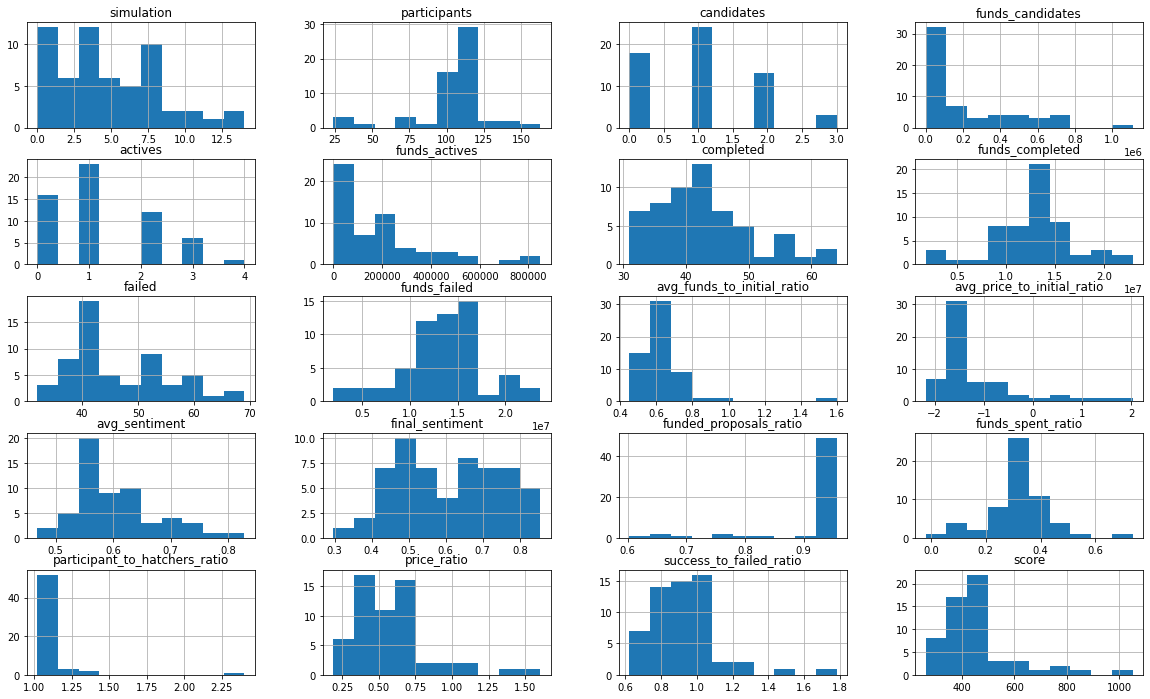

In [35]:
df_scores.hist(figsize=(20, 12));

# Sensitivity & Scoring Analysis

In [15]:
class ParamSensitivity(param.Parameterized):
        
    _cache = {}
    
    _grid_params = {
        'hatchers': list(range(10, 151, 10)),
        'proposals': list(range(5, 51, 5)),
        'hatch_tribute': np.arange(0.1, 1, 0.1).tolist(),
        'max_proposal_request': np.arange(0.1, 1, 0.1).tolist(),
        'days_to_80p_of_max_voting_weight': np.arange(15, 100, 15).tolist(),
        'exit_tribute': np.arange(0.05, 0.5, 0.05).tolist()

    }
    
    _metrics = [attr.replace('calc_', '') for attr in dir(CommonsScore) if callable(getattr(CommonsScore, attr)) and attr.startswith('calc_')]

#     variable = param.ObjectSelector(objects=['funding_pool', 'token_price', 'sentiment'], default='funding_pool')
    parameter = param.ObjectSelector(objects=[param_['name'] for param_ in grid_params], default='hatchers')
    simulation = param.ObjectSelector(objects=['All'] + [str(i) for i in range(0, 5)], default='All')
    
    def __init__(self, **params):
        self._select_simulation()
        super(ParamSensitivity, self).__init__(**params)
    
    def _cache_data(self):
        self._cache[self.parameter] = pd.read_csv(f"{DATA_PATH}/{self.parameter}.csv")
    
    @param.depends('parameter', watch=True)
    def _select_simulation(self):
        if not self.parameter in self._cache:
            self._cache_data()

        max_val = self._cache[self.parameter].simulation.max()
        self.param['simulation'].objects = ['All'] + [str(i) for i in range(0, max_val + 1)]
        self.simulation = 'All'

    @param.depends('parameter', 'variable', 'simulation')
    def view(self):
        if not self.parameter in self._cache:
            self._cache_data()
            
        if self.simulation == 'All':
            data = self._cache[self.parameter]
        else:
            data = self._cache[self.parameter][self._cache[self.parameter].simulation == int(self.simulation)]
        
        return print_pyplot(data, 
                            [self.variable], 
                            self.parameter, 
                            self._grid_params[self.parameter])
    
    @param.depends('parameter', 'simulation')
    def view_variables(self):
        if not self.parameter in self._cache:
            self._cache_data()
            
        if self.simulation == 'All':
            data = self._cache[self.parameter]
        else:
            data = self._cache[self.parameter][self._cache[self.parameter].simulation == int(self.simulation)]
        
        fig_funds = print_pyplot(data,
                                 ['funding_pool'],
                                 self.parameter,
                                 self._grid_params[self.parameter])
        
        fig_price = print_pyplot(data,
                                 ['token_price'],
                                 self.parameter,
                                 self._grid_params[self.parameter])
        
        fig_sentiment = print_pyplot(data,
                                     ['sentiment'],
                                     self.parameter,
                                     self._grid_params[self.parameter])
        
        return pn.Column(pn.panel('#### Funding Pool'), fig_funds, 
                         pn.panel('#### Token Price '), fig_price, 
                         pn.panel('#### Sentiment   '), fig_sentiment,
#                          sizing_mode='stretch_height'
                        )
    
    @param.depends('parameter', 'simulation')
    def sim_score(self):
        if self.simulation != 'All':
            fields = self._metrics + ['score']
            return df_scores[(df_scores.param == self.parameter) & (df_scores.simulation == int(self.simulation))][fields].iloc[0]
        else:
            return pn.panel("*You need to select a specific simulation*")
    
    @param.depends('parameter')
    def param_scores(self):
        return df_scores[(df_scores.param == self.parameter)]['score']
    
    @param.depends('parameter')
    def param_score_bar(self):
        df_ = df_scores[(df_scores.param == self.parameter)]['score']
        return px.bar(df_,
                      x='score',
                      color=df_.index
                     )
 

In [16]:
paramSense = ParamSensitivity(name='Parameter Sensitivity (One-at-a-time)')

In [17]:
# pn.Column(pn.Row(paramSense.param), pn.Row(paramSense.view))
score_title = "### Sim Score\n Available metrics"
scores = "### Final Score"
pn.Row(pn.Column(paramSense.param,
                 pn.panel(score_title), 
                 paramSense.sim_score,
                 pn.panel(scores),
                 paramSense.param_score_bar
                ),
       paramSense.view_variables,
#        pn.Column(paramSense.view, 
#                  pn.panel(scores), 
#                  paramSense.param_score_bar
#                 ),
      )

Row
    [0] Column
        [0] Column(margin=5, name='Parameter Sensitivity (..., width=300)
            [0] StaticText(value='<b>Parameter S...)
            [1] Select(name='Parameter', options=OrderedDict([('hatchers', ...]), value='hatchers')
            [2] Select(name='Simulation', options=OrderedDict([('All', ...]), value='All')
        [1] Markdown(str)
        [2] ParamMethod(method)
        [3] Markdown(str)
        [4] ParamMethod(method)
    [1] ParamMethod(method)

### Funding pool

In [18]:
# for param in grid_params:
#     df = pd.read_csv(f"{DATA_PATH}/{param['name']}.csv")
# #     print_plot(df, param['name'], param['values'], 'funding_pool')
#     print_pyplot(df, ['funding_pool'], param['name'], param['values'])
#     cache[param['name']] = df

### Token Price

In [19]:
# for param in grid_params:
# #     df = pd.read_csv(f"{DATA_PATH}/{param['name']}.csv") 
#     df = cache[param['name']]
# #     print_plot(df, param['name'], param['values'], 'funding_pool')
#     print_pyplot(df, ['token_price'], param['name'], param['values'])

### Introducing penalties

PARAM ==> {'name': 'hatchers', 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}
15 16
PARAM ==> {'name': 'proposals', 'values': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
10 10
PARAM ==> {'name': 'hatch_tribute', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'max_proposal_request', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'days_to_80p_of_max_voting_weight', 'values': [15, 30, 45, 60, 75, 90]}
6 6
PARAM ==> {'name': 'exit_tribute', 'values': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]}
9 10


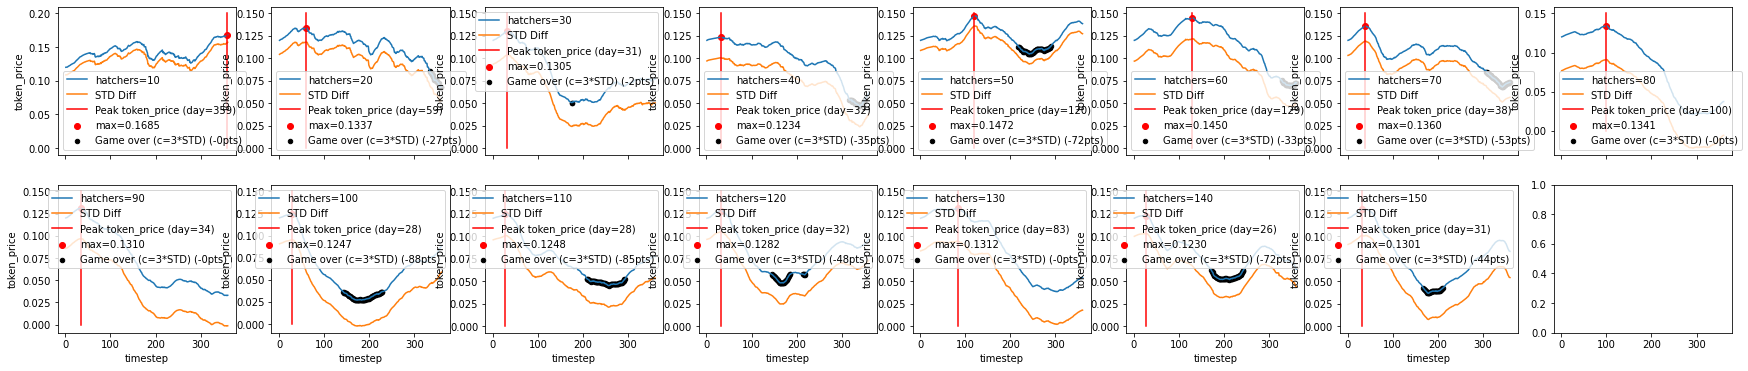

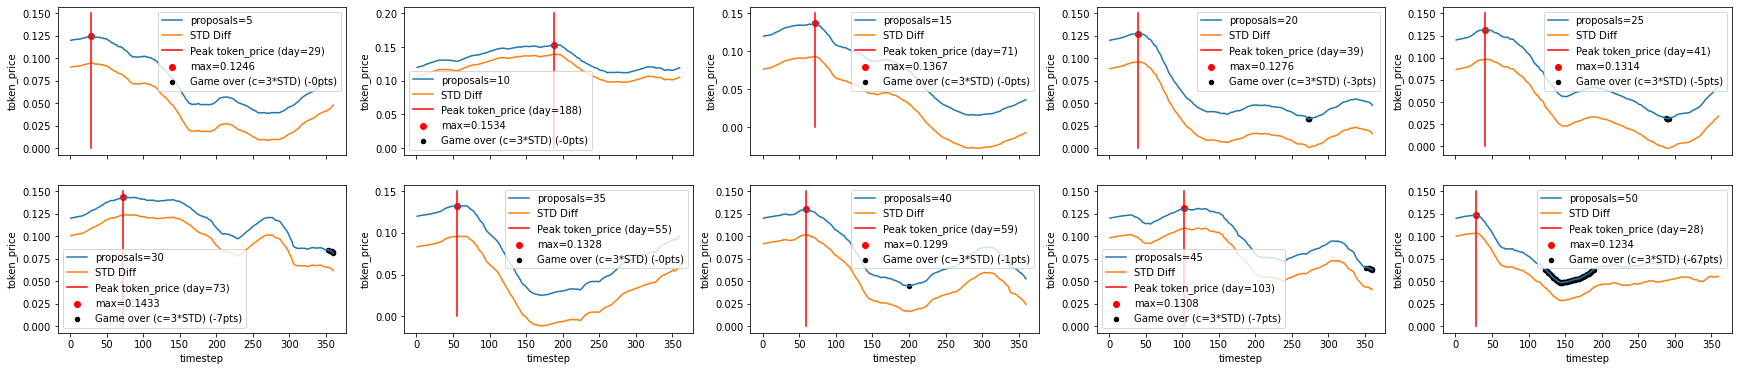

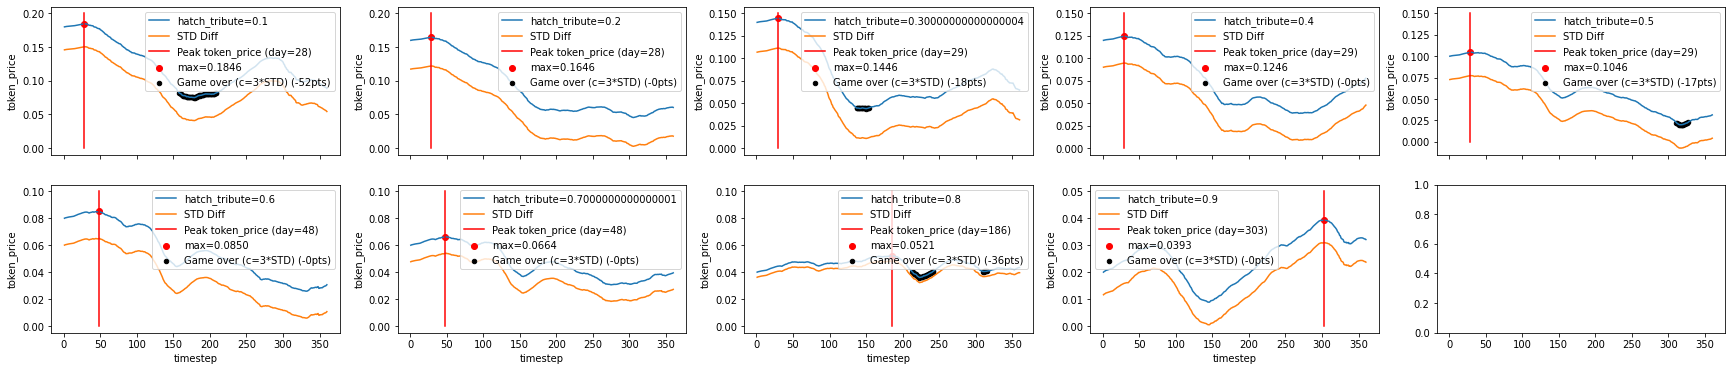

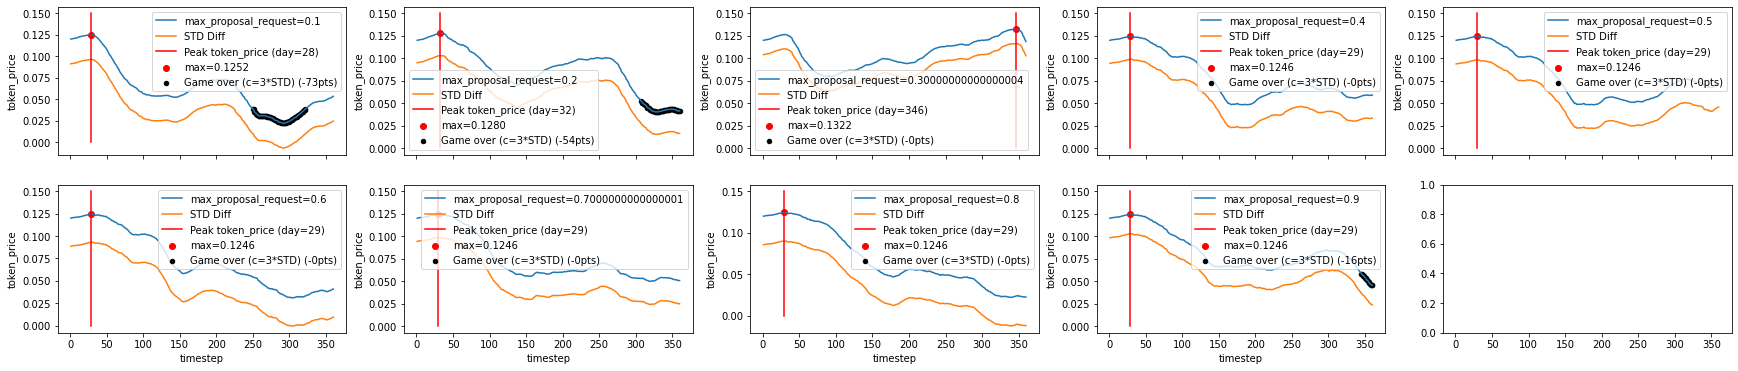

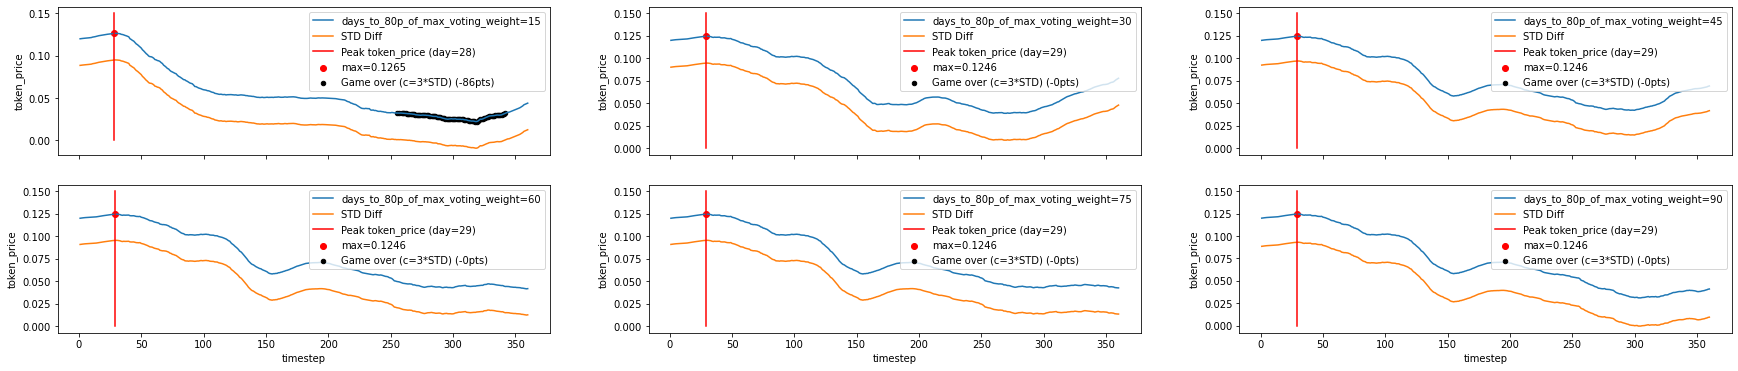

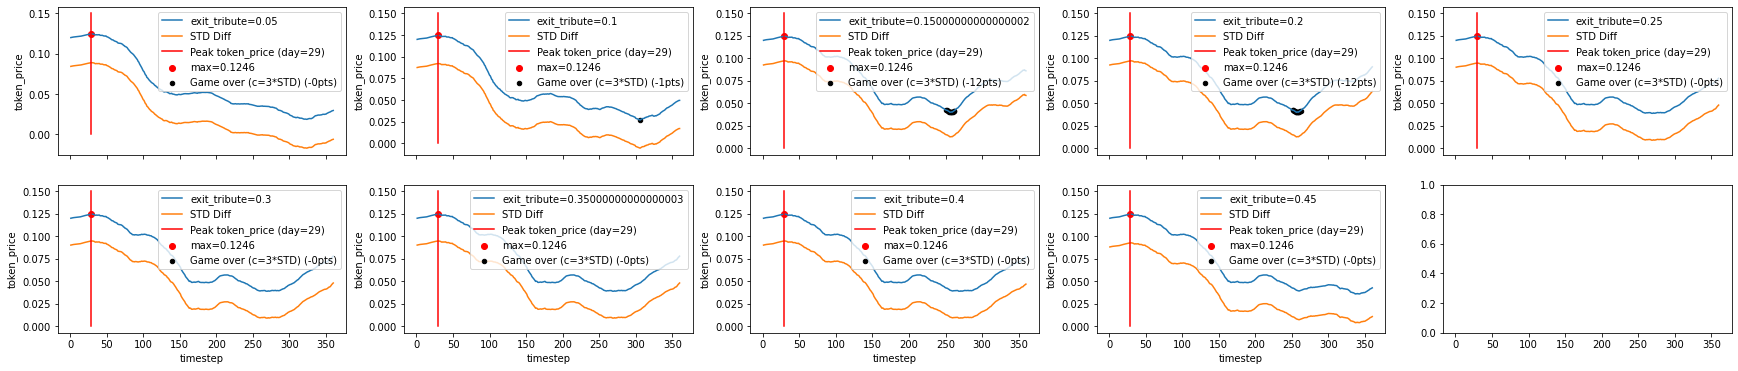

In [20]:
for param_ in grid_params:
    print(f'PARAM ==> {param_}')
    df = pd.read_csv(f"{DATA_PATH}/{param_['name']}.csv") 
    print_subplots(df, param_['name'], param_['values'], 'token_price', threshold_mult=3)

* Percentage of Change

In [21]:
# periods = [1, 5, 10, 30, 60, 90]
periods = [1, 10, 30, 60, 90]

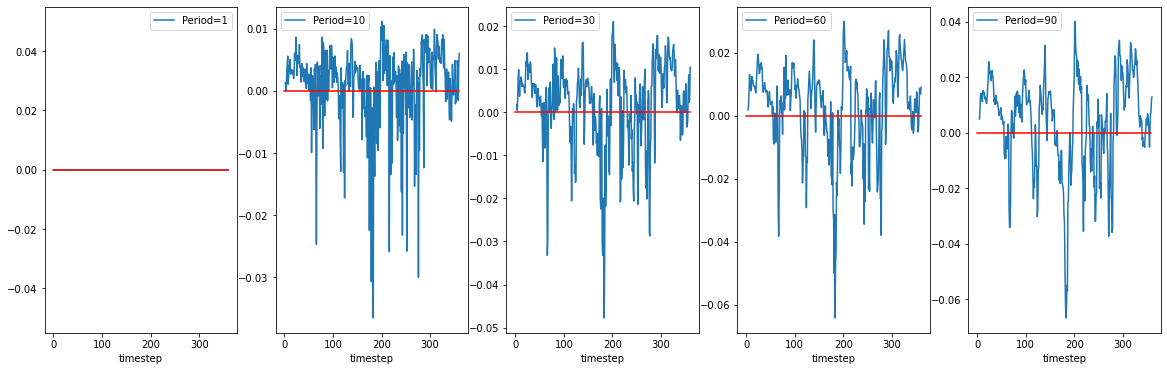

In [22]:
test = cache['hatchers'][cache['hatchers'].simulation == 0].reset_index(drop=True)

_, axs = plt.subplots(1, len(periods), figsize=(20, 6))
for i, p in enumerate(periods):
    test[f'shift_{p}'] = test.token_price.pct_change(periods=i)
    ax = test.plot('timestep', f'shift_{p}', ax=axs[i])
    ax.plot(np.arange(test.shape[0]), [0] * test.shape[0], c='red')
    axs[i].legend([f'Period={p}'])


* Rolling window

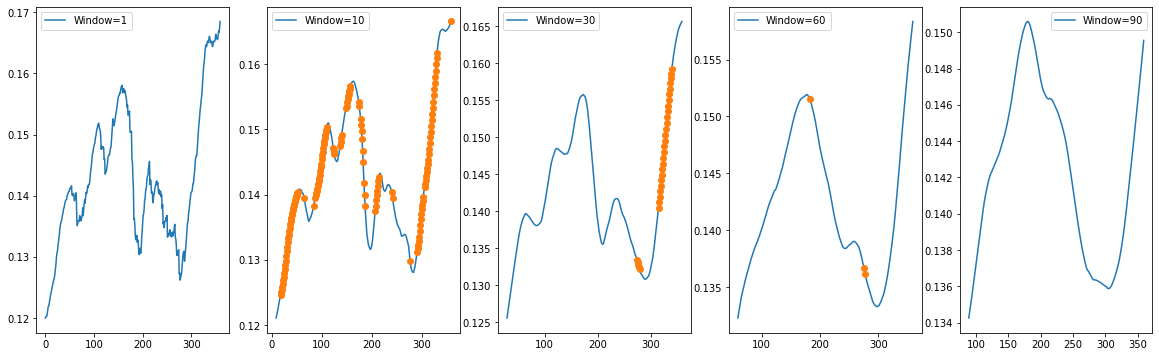

In [23]:
SIGMA = 3
_, axs = plt.subplots(1, len(periods), figsize=(20, 6))
for i, p in enumerate(periods):
    avg = test.token_price.rolling(window=p).mean()
    residual = test.token_price - avg
    std = residual.rolling(window=p).std()
#     test[f'outliers_{p}'] = avg[(np.abs(residual) > std * SIGMA)]
    ax = avg.plot(ax=axs[i])
    ax = avg[(np.abs(residual) > std * SIGMA)].plot(style='o', ax=axs[i])
#     ax = test.plot('timestep', f'outliers_{p}', ax=axs[i])
#     ax.plot(np.arange(test.shape[0]), [0] * test.shape[0], c='red')
    axs[i].legend([f'Window={p}'])

## Average Sentiment

In [24]:
# for param in grid_params:
# #     df = pd.read_csv(f"{DATA_PATH}/{param['name']}.csv")
#     df = cache[param['name']]
# #     print_plot(df, param['name'], param['values'], 'funding_pool')
#     print_pyplot(df, ['sentiment'], param['name'], param['values'])

### Introducing Penalties

 * 1 STD

PARAM ==> {'name': 'hatchers', 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}
15 16
PARAM ==> {'name': 'proposals', 'values': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
10 10
PARAM ==> {'name': 'hatch_tribute', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'max_proposal_request', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'days_to_80p_of_max_voting_weight', 'values': [15, 30, 45, 60, 75, 90]}
6 6
PARAM ==> {'name': 'exit_tribute', 'values': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]}
9 10


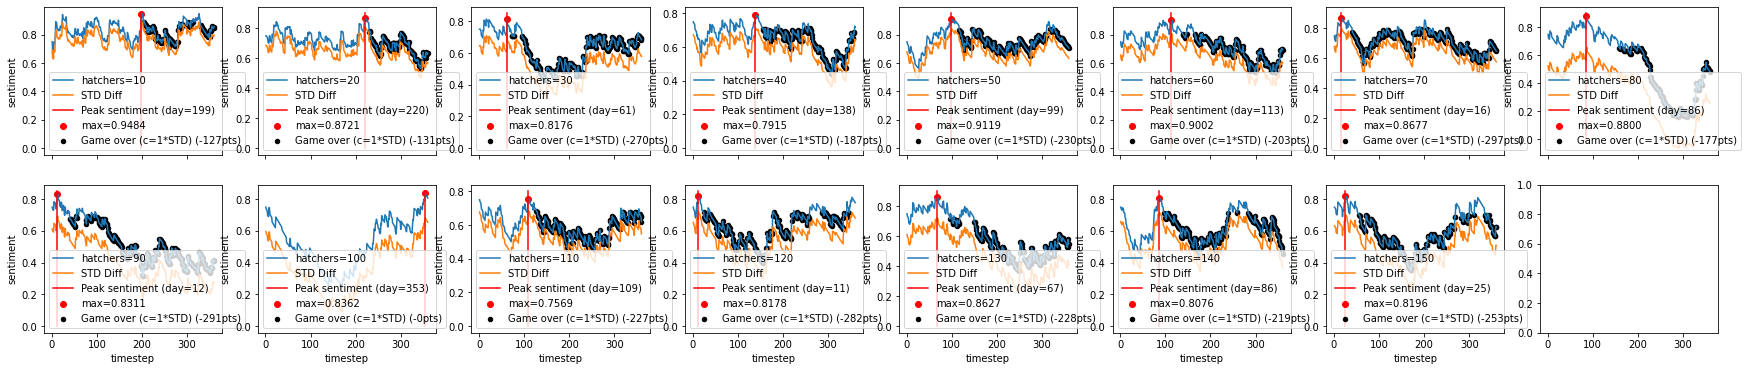

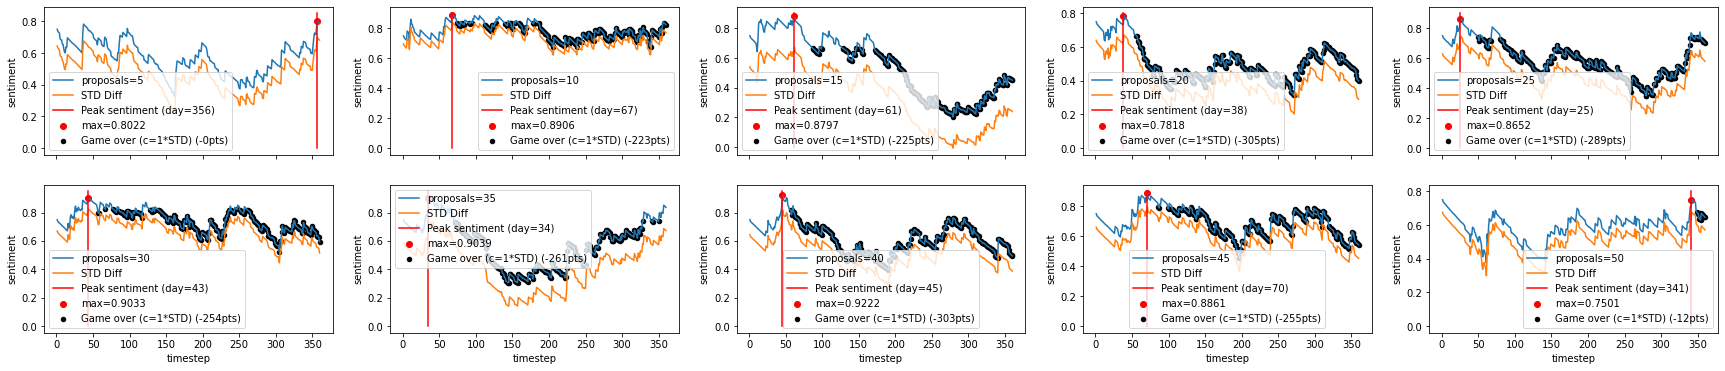

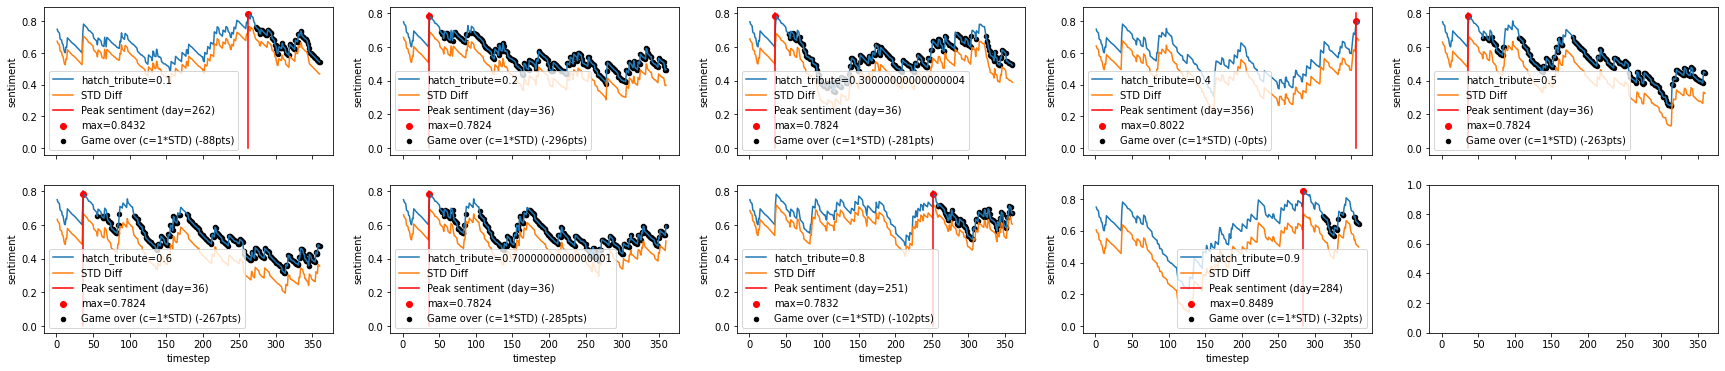

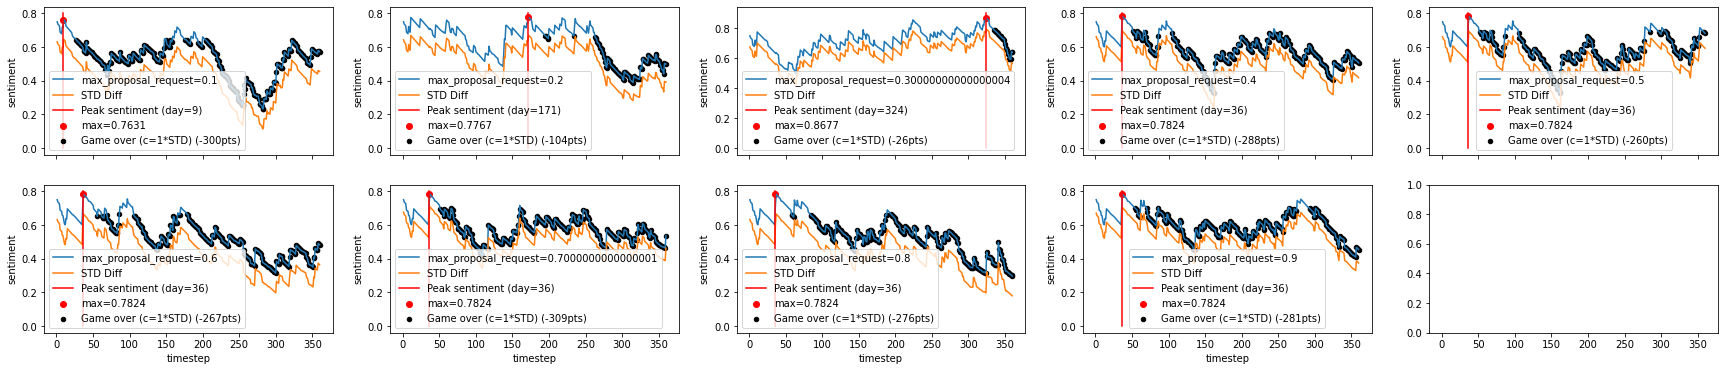

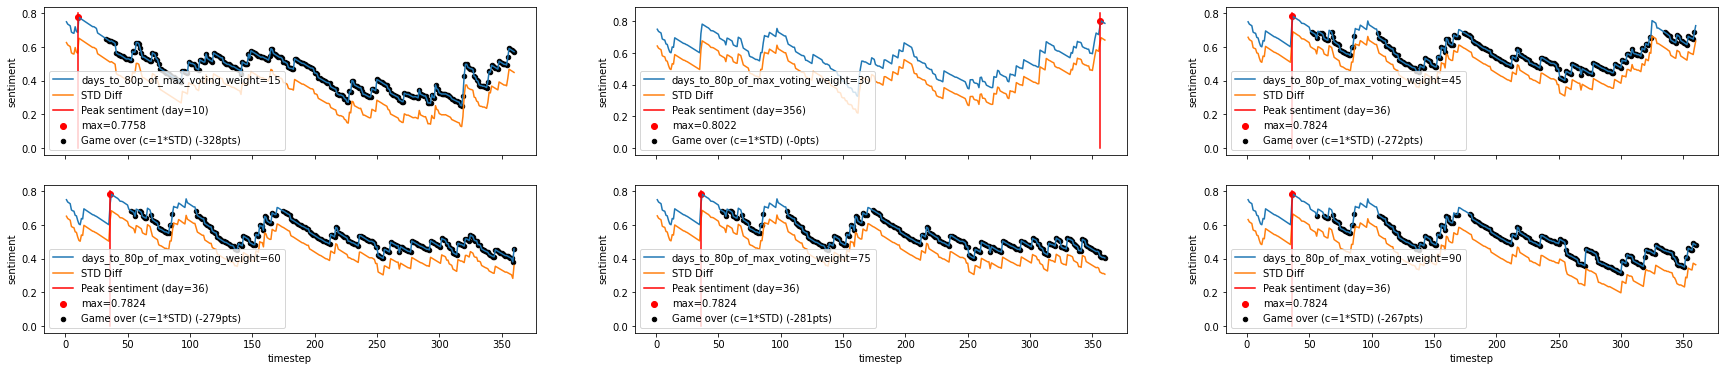

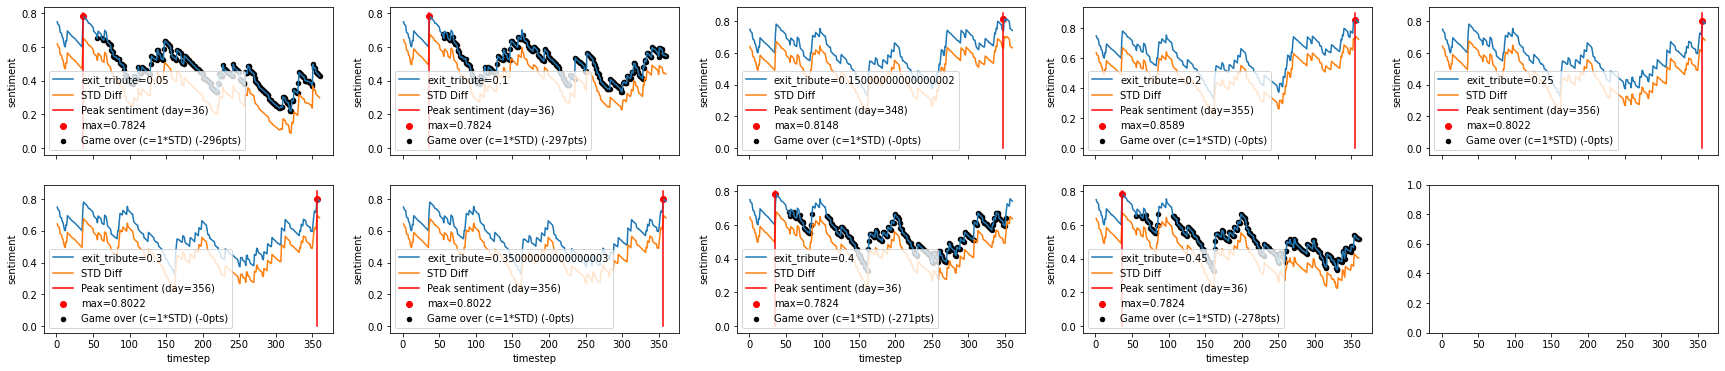

In [25]:
for param_ in grid_params:
    print(f'PARAM ==> {param_}')
    df = pd.read_csv(f"{DATA_PATH}/{param_['name']}.csv") 
    print_subplots(df, param_['name'], param_['values'], 'sentiment', threshold_mult=1)

* 2 STD

PARAM ==> {'name': 'hatchers', 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}
15 16
PARAM ==> {'name': 'proposals', 'values': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
10 10
PARAM ==> {'name': 'hatch_tribute', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'max_proposal_request', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'days_to_80p_of_max_voting_weight', 'values': [15, 30, 45, 60, 75, 90]}
6 6
PARAM ==> {'name': 'exit_tribute', 'values': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]}
9 10


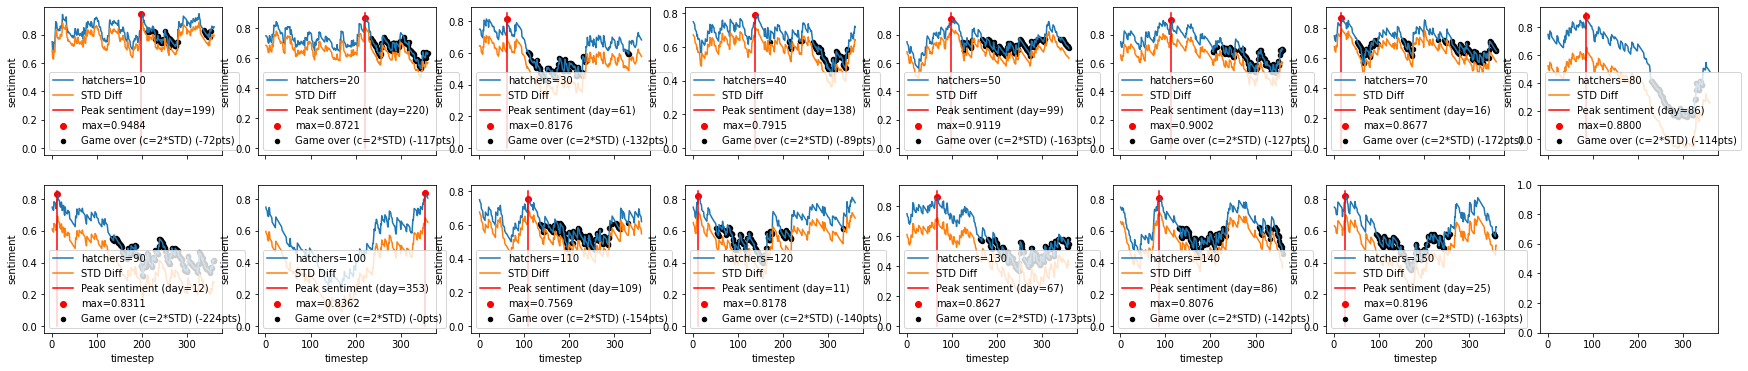

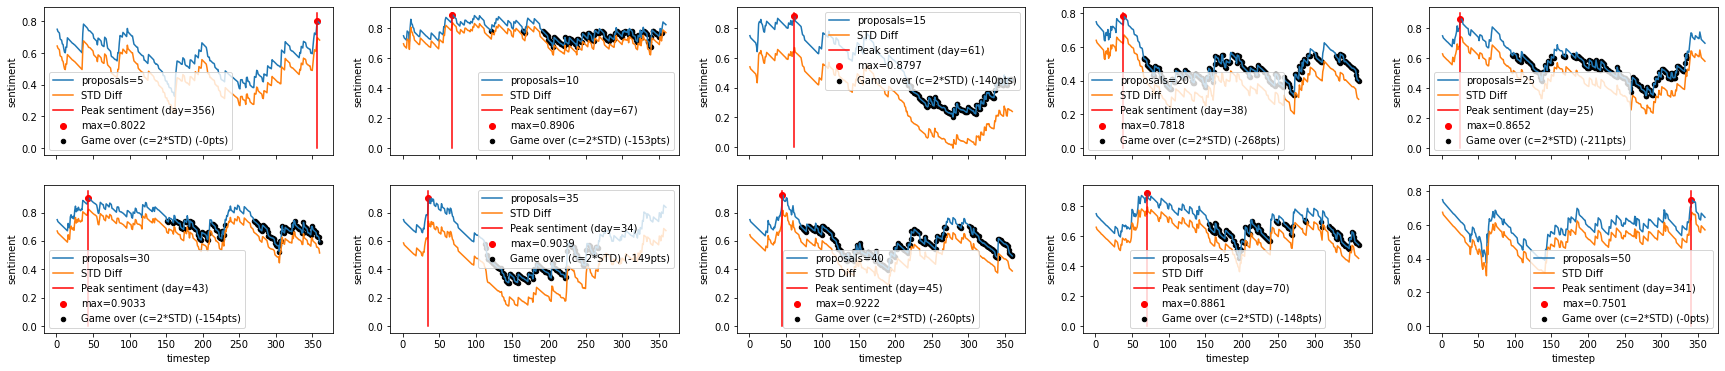

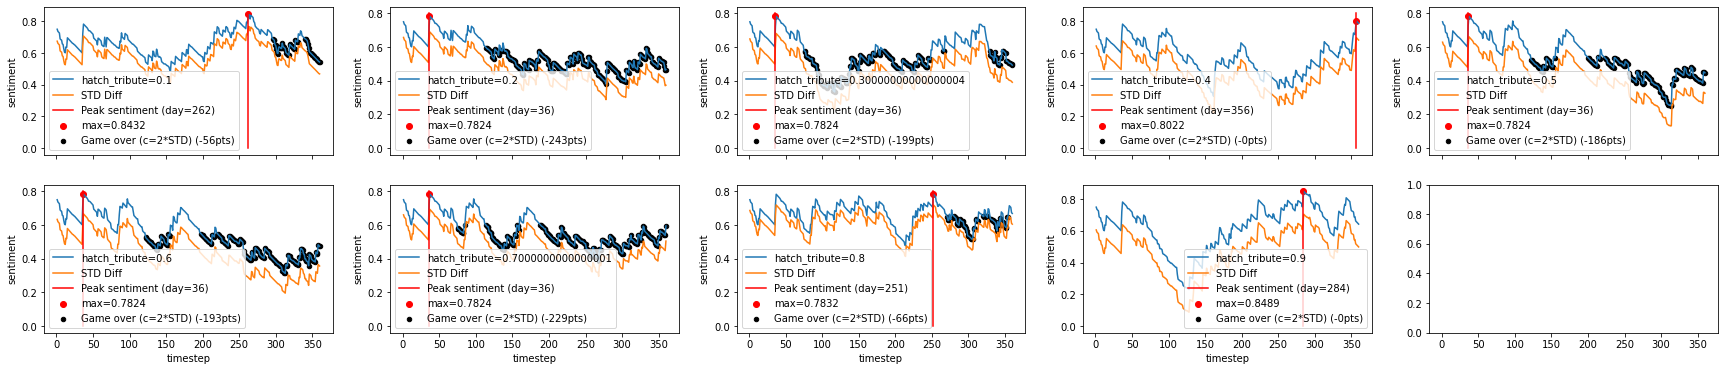

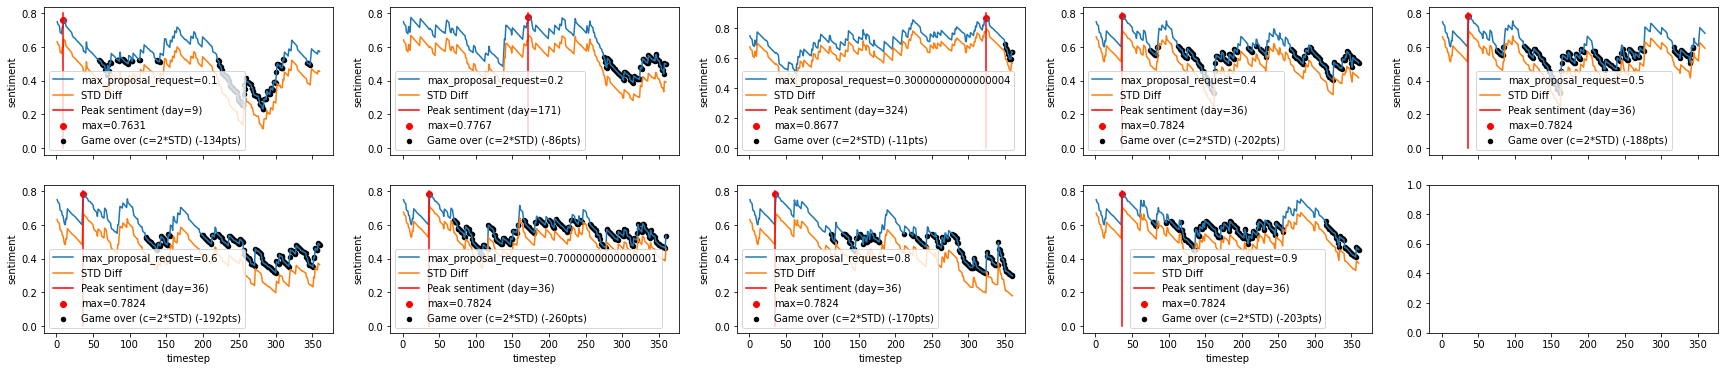

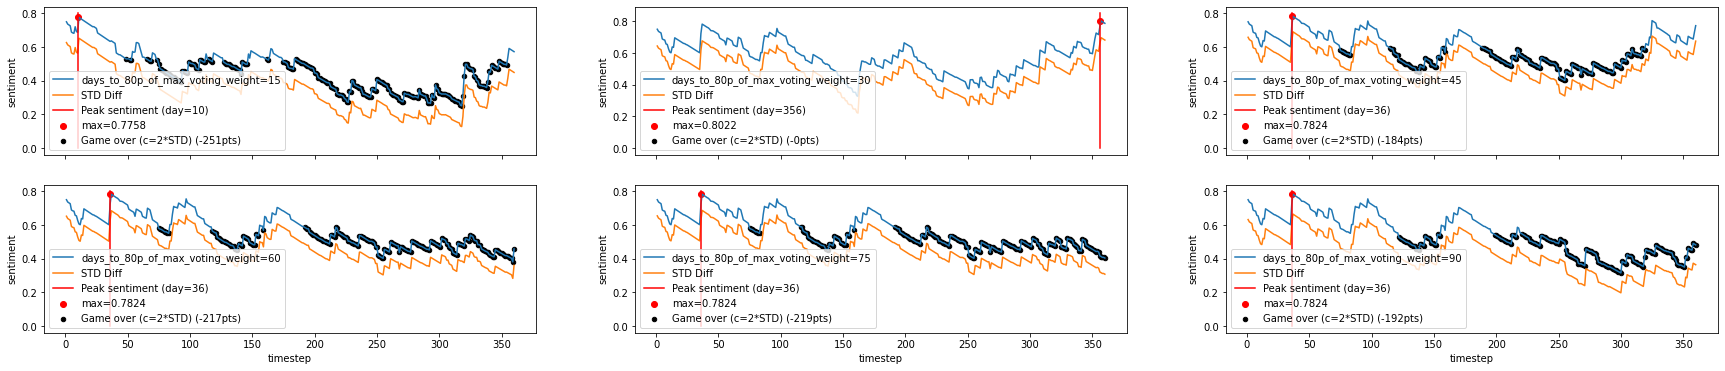

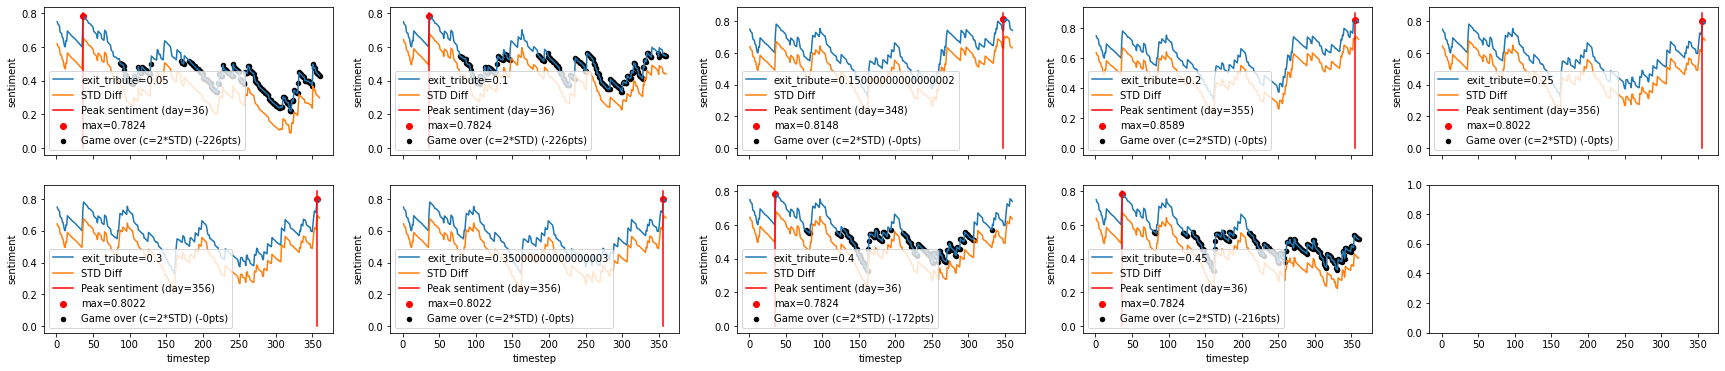

In [26]:
for param_ in grid_params:
    print(f'PARAM ==> {param_}')
    df = pd.read_csv(f"{DATA_PATH}/{param_['name']}.csv") 
    print_subplots(df, param_['name'], param_['values'], 'sentiment', threshold_mult=2)

* 3 STD

PARAM ==> {'name': 'hatchers', 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}
15 16
PARAM ==> {'name': 'proposals', 'values': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
10 10
PARAM ==> {'name': 'hatch_tribute', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'max_proposal_request', 'values': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}
9 10
PARAM ==> {'name': 'days_to_80p_of_max_voting_weight', 'values': [15, 30, 45, 60, 75, 90]}
6 6
PARAM ==> {'name': 'exit_tribute', 'values': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]}
9 10


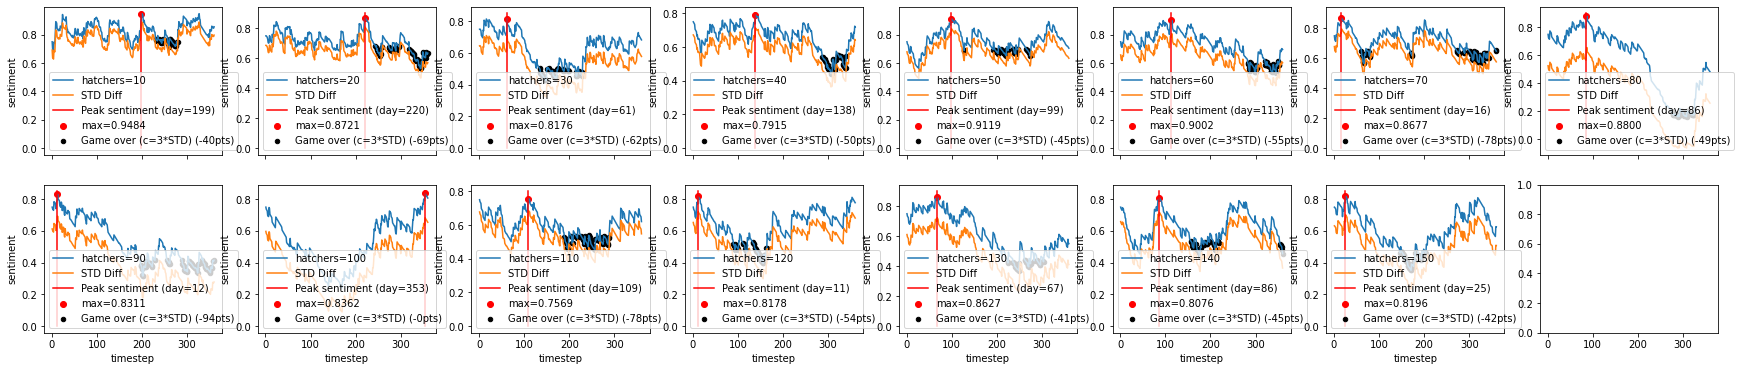

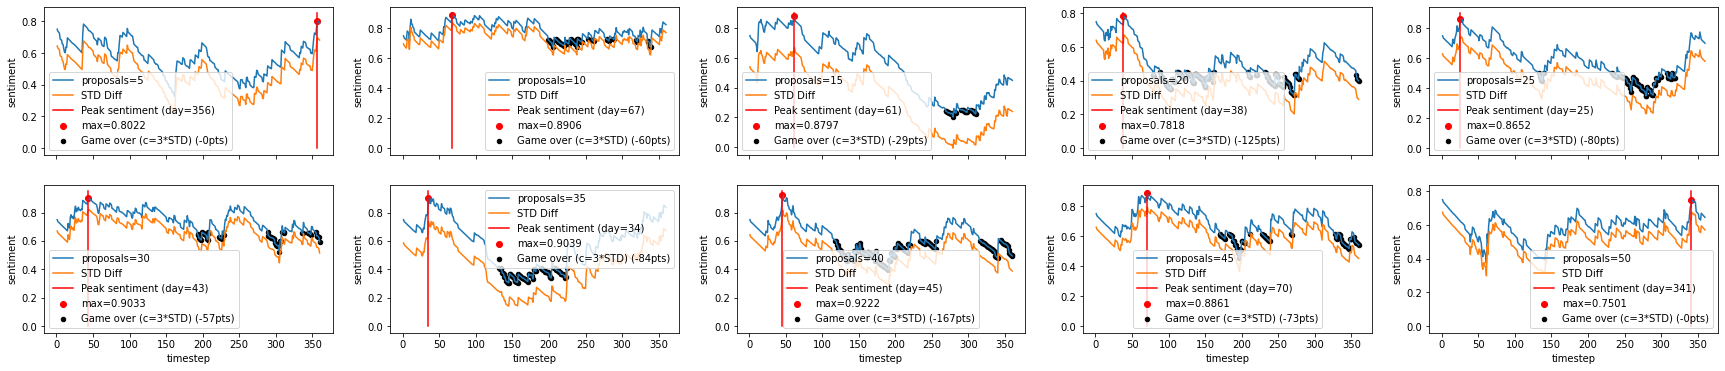

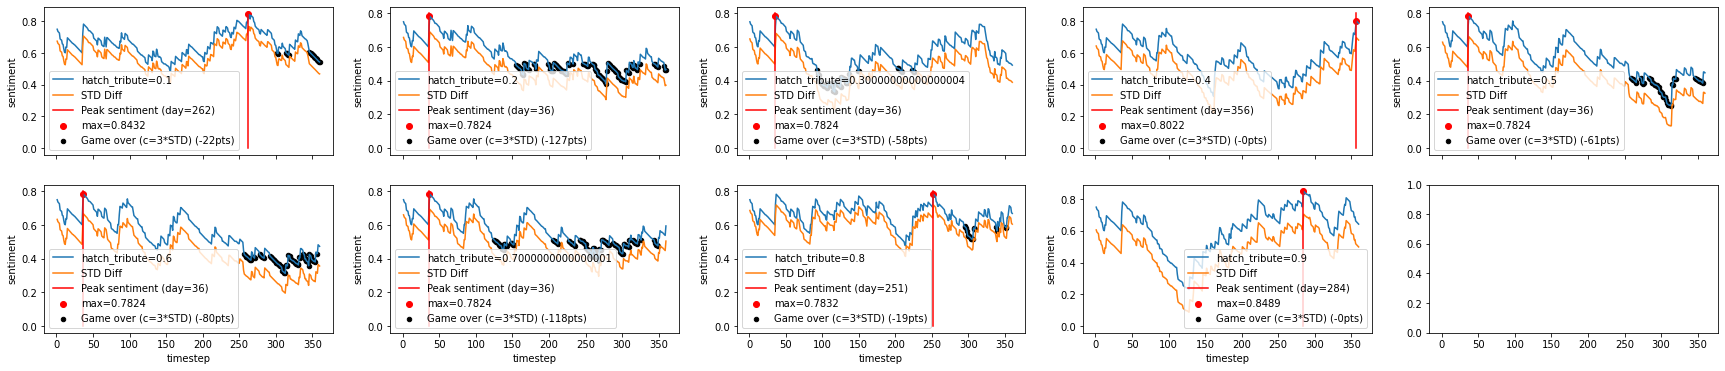

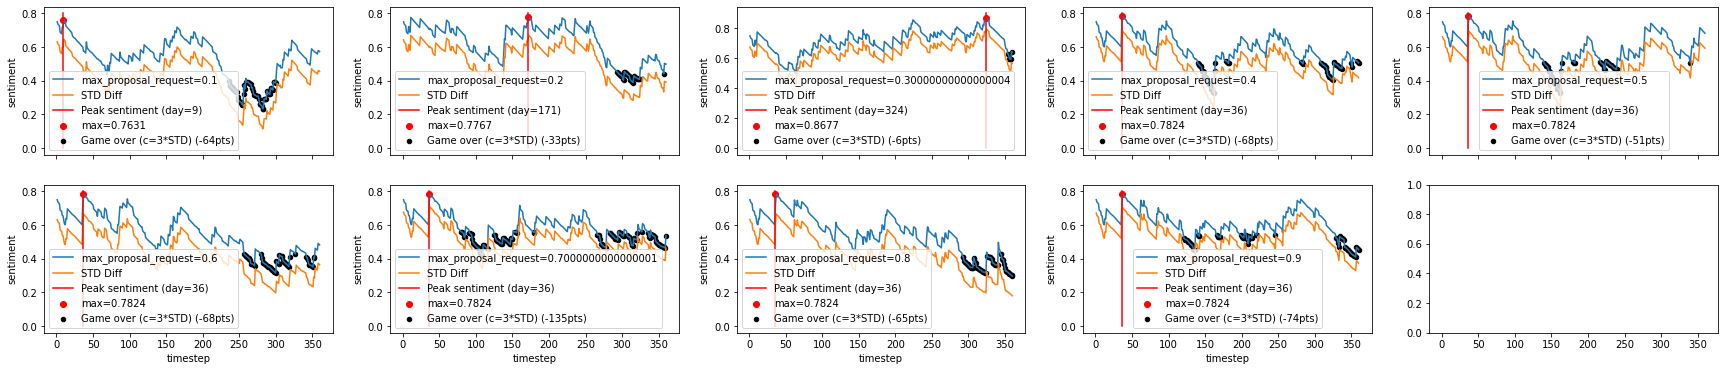

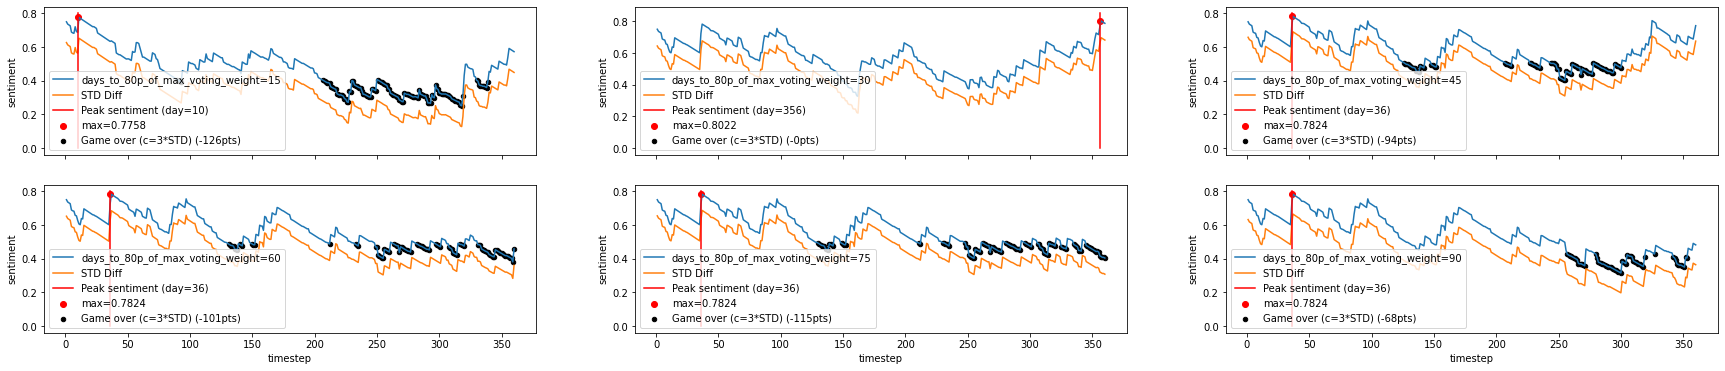

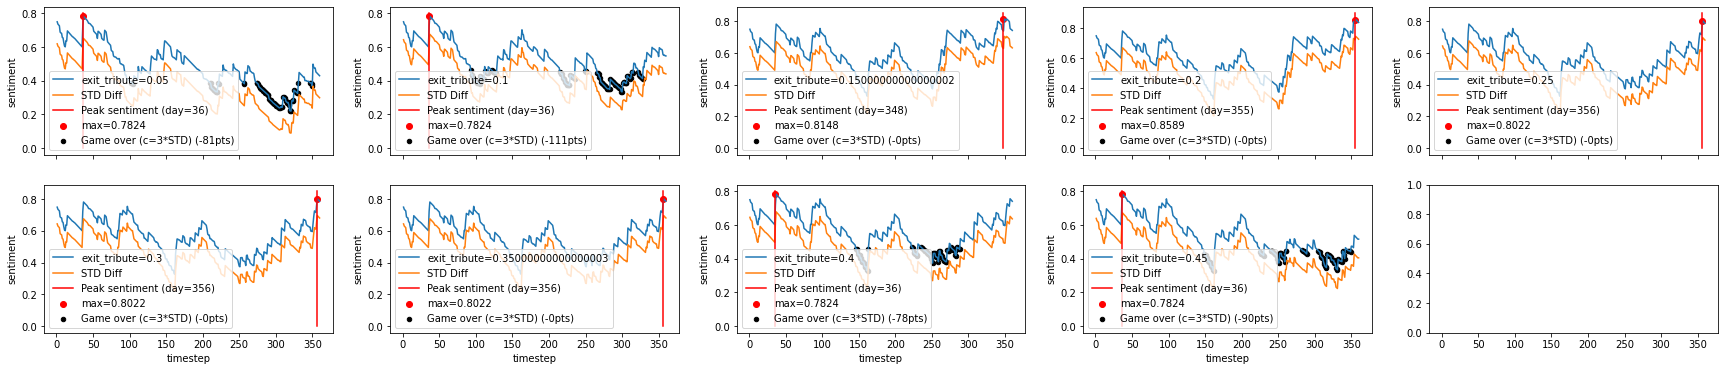

In [27]:
for param_ in grid_params:
    print(f'PARAM ==> {param_}')
    df = pd.read_csv(f"{DATA_PATH}/{param_['name']}.csv") 
    print_subplots(df, param_['name'], param_['values'], 'sentiment', threshold_mult=3)

* Percentage of change

In [28]:
test = cache['hatchers'][cache['hatchers'].simulation == 0].reset_index(drop=True)

In [29]:
for i in periods:
    test[f'shift_{i}'] = test.sentiment.pct_change(periods=i)

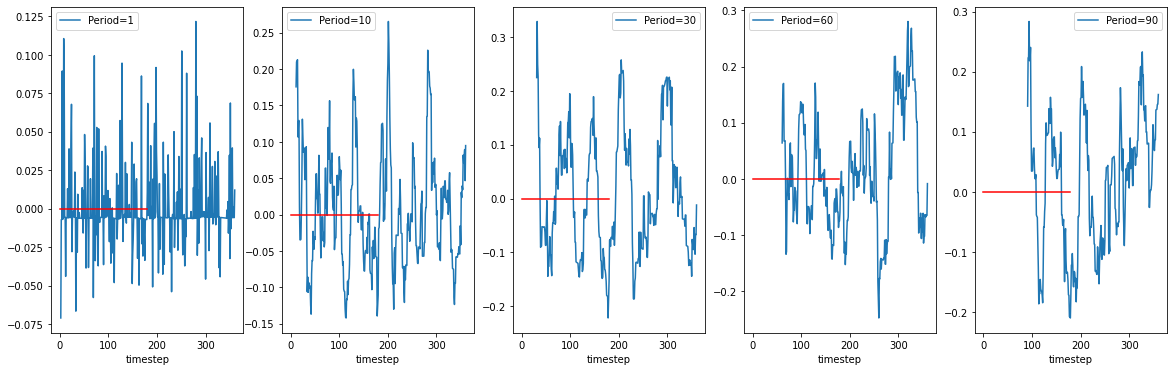

In [30]:
_, axs = plt.subplots(1, len(periods), figsize=(20, 6))
for i, p in enumerate(periods):
    ax = test.plot('timestep', f'shift_{p}', ax=axs[i])
    ax.plot(np.arange(180), [0] * 180, c='red')
    axs[i].legend([f'Period={p}'])

* Rolling window

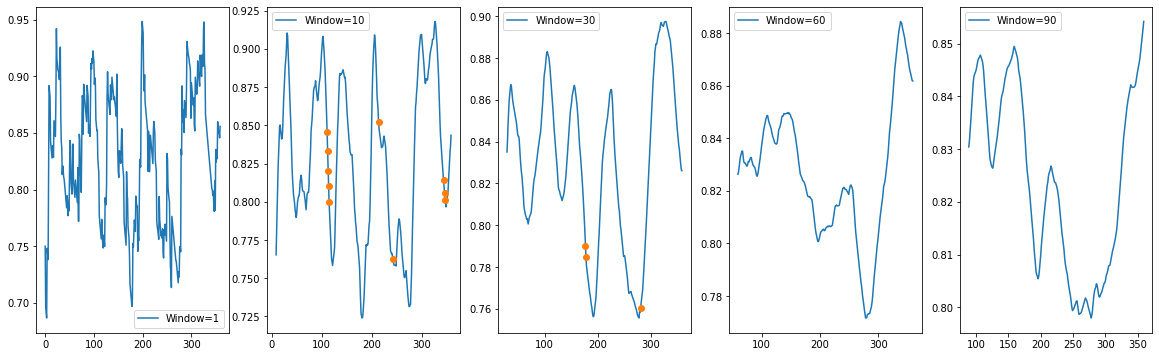

In [31]:
SIGMA = 3
_, axs = plt.subplots(1, len(periods), figsize=(20, 6))
for i, p in enumerate(periods):
    avg = test.sentiment.rolling(window=p).mean()
    residual = test.sentiment - avg
    std = residual.rolling(window=p).std()
#     test[f'outliers_{p}'] = avg[(np.abs(residual) > std * SIGMA)]
    ax = avg.plot(ax=axs[i])
    ax = avg[(np.abs(residual) > std * SIGMA)].plot(style='o', ax=axs[i])
#     ax = test.plot('timestep', f'outliers_{p}', ax=axs[i])
#     ax.plot(np.arange(test.shape[0]), [0] * test.shape[0], c='red')
    axs[i].legend([f'Window={p}'])
